# Self-Driving Car Engineer Nanodegree
## Term 1, Project 5: **Vehicle Detection and Tracking**
### Jupyter Notebook for Project: CarND-P5-VDT-StewartTeaze

In [1]:
# Import packages, setup associated shorthand names.
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline
import math
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import time
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label

## General Utility Functions

In [2]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    
    # The following line is necessary when dealing with .jpg input images, to scale them from 0-1, like the .png images
    # the classifier was trained on.
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    # Tried HSV (with HSV-trained model), but didn't work nearly as well as YCrCB (with YCrCB-trained model)
    #ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV) 
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            features = []
            cell_features = []
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            cell_features.append(spatial_features)
            cell_features.append(hist_features)
            cell_features.append(hog_feat1) # just this one, if just one channel
            cell_features.append(hog_feat2)
            cell_features.append(hog_feat3)
            features.append(np.concatenate(cell_features))
            
            # Scale features and make a prediction
            #print(spatial_features.shape, hist_features.shape, hog_features.shape)
            #myStack = np.hstack((spatial_features, hist_features, hog_features))
            #myStack = np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1)
            #print (myStack.shape)
            
            # works
            test_features = X_scaler.transform(features)  
            
            # didn't work at first - got "operands could not be broadcast together with shape" error
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

## Heat-Related Utility Functions

In [3]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## find_bboxes() Purpose-Specific Developed Function

In [4]:
# Use model with bin_spatial/color_hist/HOG features to create list of bounding boxes all predictions found
# at the requested scale, in the requested search area of the current image. 
def find_bboxes(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    #draw_img = np.copy(img)
    bboxes = []
    
    # The following line is necessary when dealing with .jpg input images, to scale them from 0-1, like the .png images
    # the classifier was trained on.
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    # Tried HSV (with HSV-trained model), but didn't work nearly as well as YCrCB (with YCrCB-trained model)
    #ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV) 
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            features = []
            cell_features = []
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG features for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color-related features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # bound up all the features values in the format expected by the trained model
            cell_features.append(spatial_features)
            cell_features.append(hist_features)
            cell_features.append(hog_feat1)
            cell_features.append(hog_feat2)
            cell_features.append(hog_feat3)
            features.append(np.concatenate(cell_features))
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(features)                    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box=((xbox_left,ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                bboxes.append(box)
                #v2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return bboxes

## Read in Provided Training Data

0.002 Seconds to read this amount of Car images: 8792
0.001 Seconds to read this amount of non-Car images: 8968


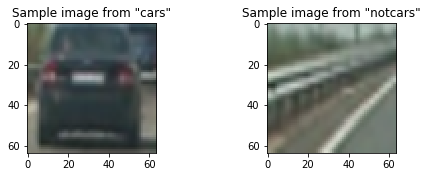

In [23]:
# Divide up provided files of training images into cars and notcars
cars = []
notcars = []

# Read in Car images
images = glob.glob('./vehicles/**/*.png', recursive=True)
t=time.time()
num_images = 0
for image in images:
    num_images += 1
    cars.append(image)
t2=time.time()
print(round(t2-t, 3), 'Seconds to read this amount of Car images:', num_images)

# Read in non-Car images
images = glob.glob('./non-vehicles/**/*.png', recursive=True)
t=time.time()
num_images = 0
for image in images:
    num_images += 1
    notcars.append(image)
t2=time.time()
print(round(t2-t, 3), 'Seconds to read this amount of non-Car images:', num_images)

# Plot one sample image from "cars", and another sample image from "notcars".
carImage = mpimg.imread('./vehicles/GTI_MiddleClose/image0001.png')
notcarImage = mpimg.imread('./non-vehicles/GTI/image8.png')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2))
f.tight_layout()
ax1.imshow(carImage)
ax1.set_title('Sample image from "cars"', fontsize=12)
ax2.imshow(notcarImage)
ax2.set_title('Sample image from "notcars"', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## "Tweakers:"

In [6]:
### Tweak these parameters and see how the results change for training, and use same parameters in find_cars for testing.
#colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#colorspace = 'HSV' # HSV better than RGB, but didn't work nearly as well as YCrCB (w/ find_cars() modified to work with HSV)
colorspace = 'YCrCb' # what had been originally hard-coded in find_cars(), seems to work best, based on limited tests
orient = 9
pix_per_cell = 8
cell_per_block = 2
#hog_channel = 0 # Can be 0, 1, 2, or "ALL"
hog_channel = "ALL" # "ALL works much better than just 0, and what had been used in find_cars()

## Set up, Train, and Perform Quick Prediction Test of Linear SVC Model

In [7]:
t=time.time()
# Extract HOG/SpatialBin/ColorHist features from input set of car images
car_features = extract_features(cars, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
# Extract HOG/SpatialBin/ColorHist features from input set of non-car images
notcar_features = extract_features(notcars, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract Combined HOG/SpatialBin/ColorHist features...')
print("Number of Car Images =", len(car_features), "Number of Non-Car Images =", len(notcar_features))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64) 
print("X.shape=", X.shape)
# Fit a per-column scaler
X_scaler = StandardScaler(copy=True, with_mean=True, with_std=True).fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
print ("scaled_X.shape=", scaled_X.shape)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 25
print('This SVC Model predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

60.74 Seconds to extract Combined HOG/SpatialBin/ColorHist features...
Number of Car Images = 8792 Number of Non-Car Images = 8968
X.shape= (17760, 8460)
scaled_X.shape= (17760, 8460)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
5.32 Seconds to train SVC...
Test Accuracy of SVC =  0.991
This SVC Model predicts:  [ 1.  0.  1.  1.  1.  0.  0.  1.  0.  1.  1.  1.  1.  0.  0.  1.  1.  0.
  1.  0.  0.  0.  0.  0.  1.]
For these 25 labels:  [ 1.  0.  1.  1.  1.  0.  0.  1.  0.  1.  1.  1.  1.  0.  0.  1.  1.  0.
  1.  0.  0.  0.  0.  0.  1.]
0.009 Seconds to predict 25 labels with SVC


## Initialize variables for find_cars() and find_bboxes() testing

In [8]:
spatial_size = (32, 32)
hist_bins = 32
#svc = LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
#     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
#     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
#     verbose=0)

### Run various tests on find_cars() on various test images, using pre-adjusted "tweakers" set up above, and adjusting the ystart, ystop, and scale parameters to determine the best parameters for searching in portions of the images, at various scales.

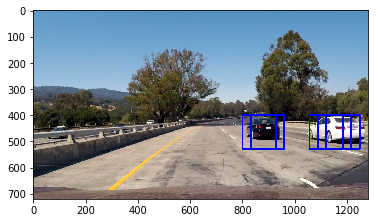

In [24]:
img = mpimg.imread('./test_images/test1.jpg')
ystart = 400
ystop = 640
scale = 2.0
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
plt.imshow(out_img)

In [ ]:
img = mpimg.imread('./test_images/test3.jpg')
ystart = 380
ystop = 520
scale = 1.0
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
plt.imshow(out_img)

In [ ]:
img = mpimg.imread('./test_images/test1.jpg')
ystart = 380
ystop = 520
scale = 1.0
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
plt.imshow(out_img)

[((800, 400), (928, 528)), ((832, 400), (960, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]


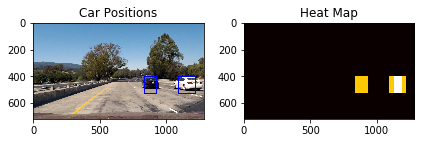

In [25]:
image = mpimg.imread('./test_images/test1.jpg')
ystart = 400
ystop = 640
scale = 2.0
box_list = find_bboxes(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
print(box_list)

heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

## process_image pipeline function

In [12]:
# rib_list is a global list containing the 4 most Recent Image's box_lists.
# rib_count is a global count of the number of RIBs (Recent Image box_lists) processed.
rib_list = [None] * 4 # Create an empty list of 4 elements
rib_count = -1
rib_index = 0

def process_image(image):
    global rib_list, rib_count, rib_index
    
    ribs_list = []
    ystart = 400; ystop = 640; scale = 2.0
    box_list1 = find_bboxes(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 380; ystop = 520; scale = 1.0
    box_list2 = find_bboxes(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    box_list = box_list1+box_list2
    
    rib_count += 1
    if rib_count <= 2: # begin filling rib list, and don't process frames until the rib_list gets "full"
        rib_list[rib_index] = box_list
        rib_index += 1
        return image
    else: 
        rib_list[rib_index] = box_list
        rib_index += 1
        if rib_index == 4:
            rib_index = 0
        
        ribs_list = rib_list[0] + rib_list[1] + rib_list[2] + rib_list[3]
            
        heat = np.zeros_like(image[:,:,0]).astype(np.float)

        # Add heat to each box in ribs_list
        heat = add_heat(heat,ribs_list)
    
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,2)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(image), labels)

        return draw_img

## process_image pipeline function Video Tests

In [13]:
# Test process_image() pipeline funstion against project_video.mp4 video input file;
# and write out the resulting video file, with lane lines overlayed, to 'test_videos_output' directory.
VDT_output = 'test_videos_output/project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
lane_clip = clip1.fl_image(process_image)
#%time lane_clip.write_videofile(VDT_output, audio=False)
lane_clip.write_videofile(VDT_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video_out.mp4
[MoviePy] Writing video test_videos_output/project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [09:29<00:00,  2.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_out.mp4 



In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(VDT_output))